# Regression lineare su grigli pixel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,80444000.0,26.048,-66.325,21.12,528,801.0,798.0,1591.9,0,119,0.00000,0.0
1,80444010.0,26.054,-66.332,21.12,528,803.0,798.0,1594.6,0,119,0.00816,10.0
2,80444020.0,26.061,-66.338,21.12,528,789.0,785.0,1593.3,0,119,0.01633,20.0
3,80444030.0,26.063,-66.342,21.12,528,785.0,790.0,1580.7,0,119,0.02449,30.0
4,80444040.0,26.066,-66.345,21.12,528,785.0,790.0,1580.7,0,119,0.03265,40.0


In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [5]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_34065/437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_34065/437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


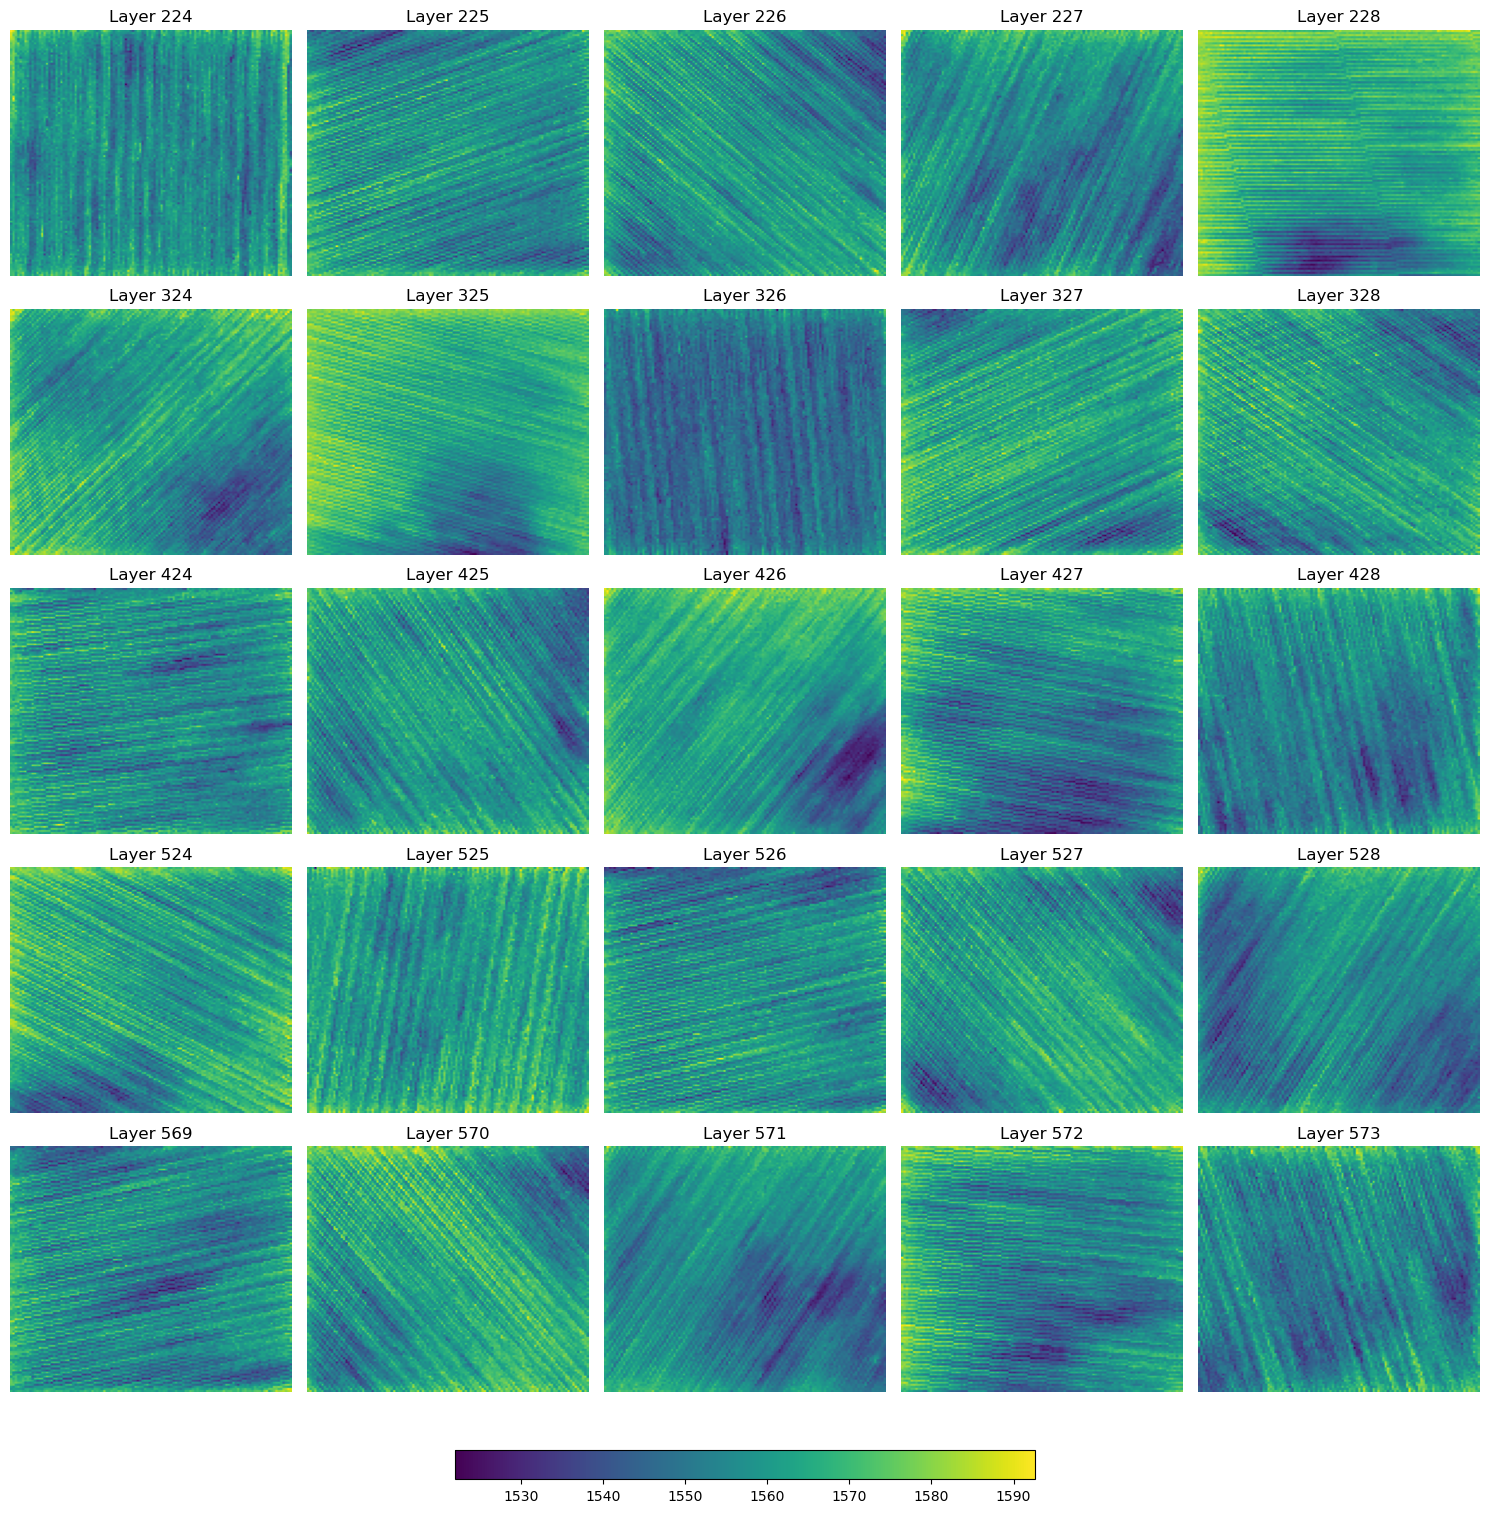

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, layer in enumerate(list_25l):
    im = axes[i].imshow(layer, aspect='auto', cmap='viridis')
    axes[i].set_title(f'Layer {layer_ids[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()

In [ ]:
# Create a reduced dataset by taking 1 value every 3 along each axis
reduced_dataset = list_25l[:, ::3, ::3]
print(reduced_dataset.shape)
reduced_dataset

(25, 40, 40)


(25, 40, 40)


In [16]:
import statsmodels.api as sm
import qdatoolkit as qda
from scipy import stats

# Use the list_25l instead of the original dataset
X = []
y = []

for layer_index, pivot_table in enumerate(list_25l):
    pivot_df = pd.DataFrame(pivot_table)  # Convert the NumPy array to a pandas DataFrame
    for x_bin, row in pivot_df.iterrows():
        for y_bin, temp in row.items():
            if not np.isnan(temp):
                X.append([layer_index, x_bin, y_bin])
                y.append(temp)

X = pd.DataFrame(X, columns=['layer_id', 'x', 'y'])
y = pd.Series(y, name='temp')
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
temp =  + 1563.124 const -0.120 layer_id -0.073 x -0.060 y

COEFFICIENTS
------------
    Term      Coef  SE Coef    T-Value     P-Value
   const 1563.1240   0.0822 19009.9089  0.0000e+00
layer_id   -0.1203   0.0037   -32.7963 1.5056e-235
       x   -0.0734   0.0008   -96.0884  0.0000e+00
       y   -0.0602   0.0008   -77.5801  0.0000e+00

MODEL SUMMARY
-------------
      S   R-sq  R-sq(adj)
15.7333 0.0441     0.0441

ANALYSIS OF VARIANCE
---------------------
    Source       DF     Adj SS     Adj MS    F-Value     P-Value
Regression      3.0 4.0416e+06 1.3472e+06 5.4424e+03  0.0000e+00
     const      1.0 8.9454e+10 8.9454e+10 3.6138e+08  0.0000e+00
  layer_id      1.0 2.6625e+05 2.6625e+05 1.0756e+03 1.5056e-235
         x      1.0 2.2855e+06 2.2855e+06 9.2330e+03  0.0000e+00
         y      1.0 1.4898e+06 1.4898e+06 6.0187e+03  0.0000e+00
     Error 353996.0 8.7627e+07 2.4754e+02        NaN         NaN
     Total 353999.0 9.1668e+07        N

In [23]:
import statsmodels.api as sm
import qdatoolkit as qda
from scipy import stats

# Use the original dataset
X = df[['layer_id', 'x', 'y']]
y = df['temp']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
qda.summary(model)



REGRESSION EQUATION
-------------------
temp =  + 1533.881 const -0.002 layer_id -0.685 x -0.711 y

COEFFICIENTS
------------
    Term      Coef    SE Coef   T-Value     P-Value
   const 1533.8815 1.7274e-01 8879.4637  0.0000e+00
layer_id   -0.0017 6.8100e-05  -25.2501 1.1566e-140
       x   -0.6854 2.4847e-03 -275.8251  0.0000e+00
       y   -0.7108 2.4805e-03 -286.5491  0.0000e+00

MODEL SUMMARY
-------------
      S  R-sq  R-sq(adj)
18.3565 0.034      0.034

ANALYSIS OF VARIANCE
---------------------
    Source        DF     Adj SS     Adj MS    F-Value     P-Value
Regression       3.0 5.3527e+07 1.7842e+07 5.2951e+04  0.0000e+00
     const       1.0 2.6568e+10 2.6568e+10 7.8845e+07  0.0000e+00
  layer_id       1.0 2.1483e+05 2.1483e+05 6.3757e+02 1.1566e-140
         x       1.0 2.5636e+07 2.5636e+07 7.6079e+04  0.0000e+00
         y       1.0 2.7668e+07 2.7668e+07 8.2110e+04  0.0000e+00
     Error 4512002.0 1.5204e+09 3.3696e+02        NaN         NaN
     Total 4512005.0 1.5739e+

In [21]:
# Get the residuals
residuals = model.resid

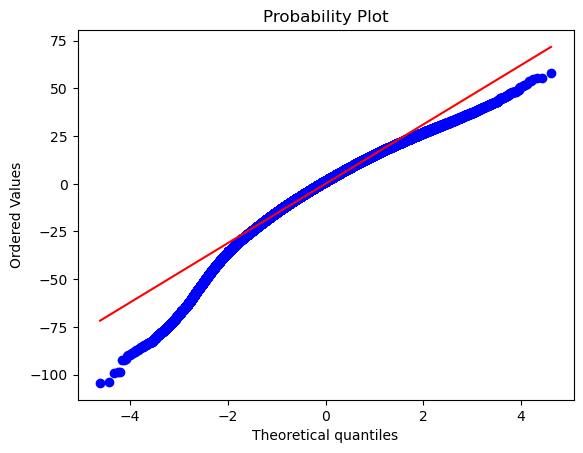

Shapiro-wilk test statistic = 0.976
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [18]:
# Check the normality of the residuals
_ = qda.Assumptions(residuals).normality()

In [ ]:
# Check the randomness of the residuals
_ = qda.Assumptions(residuals).independence()

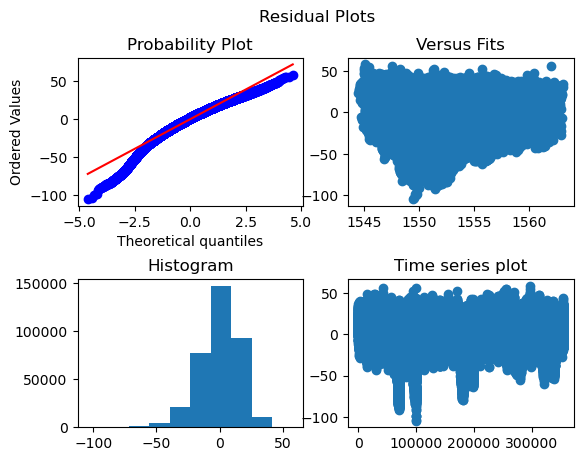

In [19]:
#NORMALITY OF RESIDUALS
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(residuals, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(model.fittedvalues, residuals)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(residuals)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
